In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
#import pandas_profiling as prof

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('../data/samsungData.txt',sep='|')

# 1 . Create train & test set

In [3]:
import random
num = int(len(data)*0.7) #number of samples
sampleddata = data.loc[random.sample(list(data.index),num)]
train = sampleddata
test = data[~data.index.isin(train.index)]

# 2. Base RF - with all variables

In [4]:
X = train[train.columns[:-2]]
Y = train.activity
randomState = 42
ntree = 25
model0 = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=True,
             oob_score=True)
model0 = model0.fit(X, Y)
model0.oob_score_

0.9621064904780412

> Sorted dataframe for variable & their importance score

In [5]:
model_vars0 = pd.DataFrame(
         {'variable':X.columns,
          'importance':model0.feature_importances_})

model_vars0.sort_values(by='importance',
                           ascending=False,
                           inplace=True)

> selected variables (5) from top 15

In [6]:
n_used = 4
cols_model = [col for col in model_vars0.variable[:n_used].values] + [model_vars0.variable[6]]

## 3.a. SVM

In [7]:
X = train[cols_model]
Y = train.activity

In [8]:
Y_test = test.activity
X_test = test[X.columns]

In [9]:
from sklearn import svm

clf = svm.SVC()
clf = clf.fit(X, Y)
y_predicted = clf.predict(X_test)
trains = clf.score(X,Y)
tests = clf.score(X_test,y_predicted)
'SVM fitting scores: Training %.4f Testing %.4f'%(trains , tests)

'SVM fitting scores: Training 0.8348 Testing 1.0000'

## 3.b. SVM - different parameters

In [10]:
clf_n = svm.SVC()
model0 = clf_n.fit(X,Y)

y_predTrain = model0.predict(X)
y_predTest = model0.predict(X_test)

train_acc = accuracy_score(Y,y_predTrain)
test_acc = accuracy_score(Y_test,y_predTest)
'SVM fitting scores: Training %.4f Testing %.4f'%(train_acc , test_acc)

'SVM fitting scores: Training 0.8348 Testing 0.8237'

#### Train results

In [11]:
confusion_matrix(Y,y_predTrain)

array([[981,   0,   0,   0,   0,   0],
       [  0, 751, 133,   1,   0,   0],
       [  0, 117, 834,   0,   0,   0],
       [  0,   0,   0, 708,  66, 112],
       [  0,   0,   0, 112, 528,  49],
       [  0,   0,   0, 217,  43, 494]])

#### Test results

In [12]:
Y_test.groupby(Y_test).count()

activity
laying      426
sitting     401
standing    423
walk        340
walkdown    297
walkup      319
Name: activity, dtype: int64

In [13]:
np.unique(Y_test)

array(['laying', 'sitting', 'standing', 'walk', 'walkdown', 'walkup'], dtype=object)

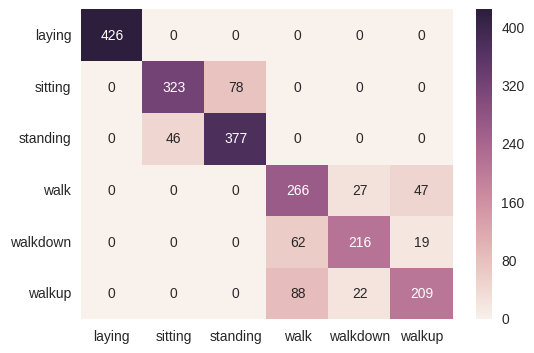

In [25]:
sns.heatmap(data=confusion_matrix(Y_test,y_predTest),
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(Y_test),
            yticklabels=np.unique(Y_test))

In [15]:
labels = {0: 'walk', 1: 'walkup', 2: 'walkdown', 3: 'sitting', 4: 'standing', 5: 'LAYING'}

## 4. Getting & plotting results from original results

In [20]:
yPred = range(len(y_predicted))
for j in range(len(labels)):
    lc = labels.values()[j].lower() #current label
    kc = labels.keys()[j]-1
    for i in range(len(y_predicted)):
        yc = y_predicted[i].lower()
        if yc == lc:
            yPred[i] = kc

In [21]:
ytestreat = range(len(Y_test))
for j in range(len(labels)):
    lc = labels.values()[j].lower() #current label
    kc = labels.keys()[j]-1
    for i in range(len(y_predicted)):
        yc = y_predicted[i].lower()
        if yc == lc:
            ytestreat[i] = kc

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ytestreat, yPred))
print 'RMS %.4f' % rms

RMS 0.0000


Confusion matrix, without normalization
[[441   0   0   0   0   0]
 [  0 278   0   0   0   0]
 [  0   0 246   0   0   0]
 [  0   0   0 357   0   0]
 [  0   0   0   0 442   0]
 [  0   0   0   0   0 442]]


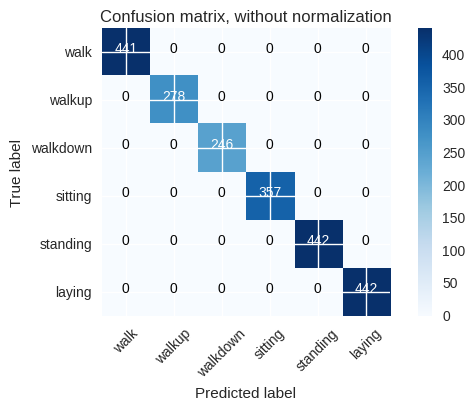

In [23]:
import itertools
class_names = ['walk', 'walkup','walkdown', 'sitting', 'standing', 'laying']


from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix
cnf_matrix = confusion_matrix(ytestreat, yPred)
np.set_printoptions(precision=2)
    
#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                     title='Confusion matrix, without normalization')

plt.show()